# 1. 데이터 로드 & 전처리

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_dir = os.path.join(os.getenv('HOME'), 'work/AIFFEL_practice/exploration/kaggle_house/data')

train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


baseline과 다르게 date를 int형 데이터로 처리할 것.

In [5]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [6]:
# 타겟 칼럼 삭제
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [7]:
# id 삭제
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
# test 데이터도 작업
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


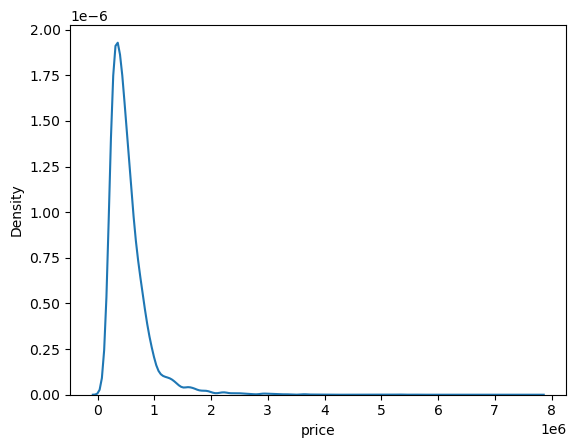

In [10]:
sns.kdeplot(y)
plt.show()

왼쪽으로 크게 치우쳐 있음 -> log 변환

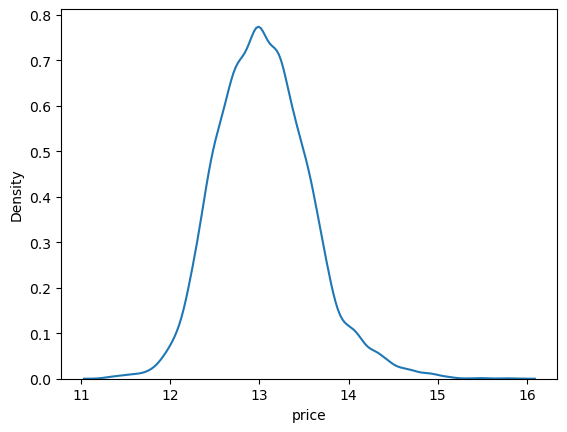

In [11]:
y = np.log(y)

sns.kdeplot(y)
plt.show()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 2. 함수 정의

먼저, 대회 평가 척도인 RMSE 함수를 생성하는데,  
주의할 점은 y_test, t_pred는 log 변환이 돼있는 상태이다.  
따라서 다시 expm1()함수로 되돌려 줘야함.

In [14]:
# 1. rmse 함수 정의
def RMSE(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [17]:
# 2. 모델 정의
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값
random_state = 2025

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [18]:
# 각 모델의 이름은 아래와 같이 __name__ 속성에 접근해서 얻을 수 있다.
gboost.__class__.__name__

'GradientBoostingRegressor'

In [21]:
# 3. 학습 및 예측
df = {}

for model in models:
    # 모델 이름 저장
    model_name = model.__class__.__name__

    # train, test 데이터셋 8:2로 분리
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.2,
                                                       random_state = random_state)

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 RMSE값 저장
    df[model_name] = RMSE(y_test, y_pred)

    # dataframe에 저장
    score_df = pd.DataFrame(df, index=["RMSE"]).T.sort_values("RMSE", ascending=False)

df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2303
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047059


{'GradientBoostingRegressor': np.float64(147091.26523592634),
 'XGBRegressor': np.float64(137073.8356323333),
 'LGBMRegressor': np.float64(140783.2911400875),
 'RandomForestRegressor': np.float64(152695.86616902944)}

위 과정을 함수로 정의

In [22]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

# 3. 하이퍼 파라미터 튜닝

**그리드 탐색**  
- 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색.
- 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리함
- 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있음.

**랜덤 탐색**
- 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법
- 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 항상 열려있음. 다만 보장은 없다.  

파라미터를 입력하면 가능한 모든 조합을 탐색하는 사이킷런의 GridSearchCV를 활용할 것이다.  

GridSearchCV에 입력되는 인자:
- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [24]:
# 탐색할 xgboost 관련 하이퍼 파라미터 준비
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [25]:
# 모델 준비
model = LGBMRegressor(random_state=random_state)

In [26]:
grid_model = GridSearchCV(model, param_grid=param_grid,
                         scoring = 'neg_mean_squared_error',
                         cv=5, verbose=1, n_jobs=5)
grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.050185
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2025), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

totalling 20 fits의 의미는?  
n_estimators, max_depth 각각 두 가지를 넣었으니 가능한 조합은 2x2 = 4가지.  
cross validation = 5이므로 각 경우마다 5번을 진행하니 총 20 fits 진행.

In [28]:
# 결과는 아래에 저장됨
grid_model.cv_results_ 

{'mean_fit_time': array([0.42453041, 0.48038983, 0.86842732, 1.17352524]),
 'std_fit_time': array([0.06509702, 0.06834775, 0.09272625, 0.18687354]),
 'mean_score_time': array([0.02942281, 0.03316031, 0.04121161, 0.04740481]),
 'std_score_time': array([0.01513428, 0.01193301, 0.01324475, 0.01962381]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value=999999),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.07569776, -0.05555679, -0.02885862, -0.02665442]),
 'split1_test_score': array([-0.07666484, -0.05787629, -0.03041482, -0.02795911]),
 'split2_test_score': array([-0.0735494 , -0.05546107, -0.0306855 , -0.02834129]),
 'spl

여기서 우리가 관심 있는 정보는?  
어떤 파라미터 조합일 때 점수가 어떻게 나오는 것인지.  
- 파라미터 조합은 params, 테스트 점수는 mean_test_score에 있다.

In [30]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [31]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339482, -0.0550207 , -0.0291775 , -0.02702729])

In [32]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073395
1,1,100,-0.055021
2,10,50,-0.029177
3,10,100,-0.027027


여기서 score가 음수인 이유는?  
- CridSearchCV에서 모델을 초기화할 때 scoring 인자에 neg_mean_squared_error을 넣었기 때문

In [33]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073395,0.270915
1,1,100,-0.055021,0.234565
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164400


RMSE 값을 구했는데 위의 "2. 함수 정의" 단계에서 확인했던 10만 단위의 RMSE 값과는 다른 스케일이다. 그 이유는?  
- price에 대해 log 변환을 했기 때문에 먼저 expm1()를 이용해서 다시 지수변환을 한 후 RMSE 값을 계산했었다.
- 하지만 그리드 탐색 과정에서는 지수변환을 하지 않았어서 log 변환 되어있는 price 데이터에서 손실함수 값을 계산한 것.
- 따라서 방금 구한 건 RMSE가 아니라 RMSLE이다.

In [34]:
# 이름 변환
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073395,0.270915
1,1,100,-0.055021,0.234565
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164400


In [36]:
# RMSLE가 낮은 순서대로 정렬
results.sort_values("RMSLE", inplace=True)
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164400
2,10,50,-0.029177,0.170814
1,1,100,-0.055021,0.234565
0,1,50,-0.073395,0.270915


이제 위의 과정을 함수로 만들어서 간결한 코드를 만들자.  
1. GridSearchCV 모델로 'model'을 초기화
2. 모델을 fitting
3. params, score에 각 조합에 대한 결과를 저장
4. 데이터프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬

In [39]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error',
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # df 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results.sort_values("RMSLE", inplace=True)

    return results

In [40]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2332
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.050658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164400
2,10,50,-0.029177,0.170814
1,1,100,-0.055021,0.234565
0,1,50,-0.073395,0.270915


가장 좋은 조합은 10, 100  
이 파라미터로 구성된 모델을 학습시키고 예측 결과 생성

In [41]:
model = LGBMRegressor(max_depth=10, n_estimator=100, random_state=random_state)
model.fit(train, y)
y_pred = model.predict(test)

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048120
[LightGBM] [Warning] Unknown parameter: n_estimator

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

***** **중요** *****  
예측 결과에 np.expm1()로 다시 지수변환 해야함 !!!

In [42]:
y_pred = np.expm1(y_pred)

In [44]:
# 이제 제출
sub = pd.read_csv("~/work/AIFFEL_practice/exploration/kaggle_house/data/sample_submission.csv")
sub.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [45]:
# price에 예측값 채우기
sub['price'] = y_pred
sub.head()

,id,price
0,15035,5.067656e+05
1,15036,4.795051e+05
2,15037,1.345154e+06
3,15038,3.122568e+05
4,15039,3.338635e+05


In [47]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format('~/work/AIFFEL_practice/exploration/kaggle_house/data', 'lgbm', '0.164400')
sub.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

~/work/AIFFEL_practice/exploration/kaggle_house/data/submission_lgbm_RMSLE_0.164400.csv


이 모든 과정을 하나의 함수로 정의

In [48]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '~/work/AIFFEL_practice/exploration/kaggle_house/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [49]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Warning] Unknown parameter: n_estimator
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048120
[LightGBM] [Warning] Unknown parameter: n_estimator
~/work/AIFFEL_practice/exploration/kaggle_house/data/submission_lgbm_RMSLE_0.164399.csv saved!
